In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [63]:
df = pd.read_csv('breast-cancer.csv')

In [64]:
# Check columns
print("Columns:", df.columns)

Columns: Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [65]:
# STEP 2: Clean non-numeric data
# Example: if 'diagnosis' column has 'B'/'M', map to 0/1
if 'diagnosis' in df.columns:
    df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})
    target_col = 'diagnosis'
elif 'target' in df.columns:
    df['target'] = df['target'].map({'B': 0, 'M': 1})
    target_col = 'target'
else:
    raise ValueError("Cannot find 'diagnosis' or 'target' column for labels!")

In [66]:
# STEP 3: Drop non-feature columns (like 'id' if exists)
if 'id' in df.columns:
    df = df.drop(columns=['id'])

In [67]:


# STEP 4: Prepare X (features) and y (labels)
X = df.drop(columns=[target_col]).values
y = df[target_col].values


In [68]:
# STEP 5: Split train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [69]:
# STEP 6: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# STEP 7: Train Linear SVM
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy: {acc_linear:.2f}")

Linear SVM Accuracy: 0.96


In [71]:
# STEP 8: Train RBF SVM
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF SVM Accuracy: {acc_rbf:.2f}")

RBF SVM Accuracy: 0.97


In [72]:
# STEP 9: Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [73]:
# Train again on 2D for plotting
svm_rbf_2d = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf_2d.fit(X_train_pca, y_train)


SVC(C=1)

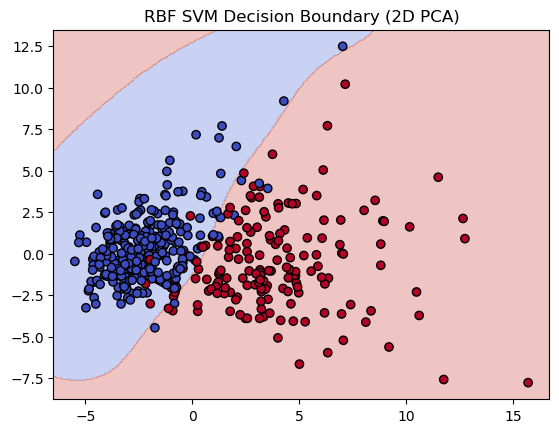

In [74]:
# Plot decision boundary
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.show()

plot_decision_boundary(svm_rbf_2d, X_train_pca, y_train, 'RBF SVM Decision Boundary (2D PCA)')


In [75]:

# STEP 10: Hyperparameter tuning (C, gamma)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best parameters from GridSearch:", grid.best_params_)
print("Best cross-validation score from GridSearch:", grid.best_score_)

Best parameters from GridSearch: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score from GridSearch: 0.9758241758241759


In [76]:
# STEP 11: Cross-validation performance
best_svm = grid.best_estimator_
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")

Cross-validation scores: [0.96703297 1.         0.96703297 0.96703297 0.97802198]
Mean cross-validation score: 0.98
